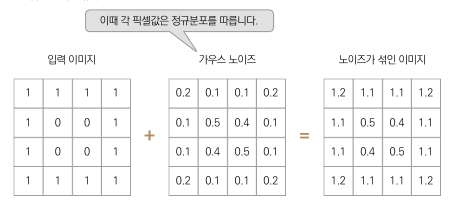

오토인코더
  - 입력을 그대로 출력으로 보냄
  - 어느정도 노이즈가 섞여있어도 원본을 복원
  - Convolution을 사용
  - Auto Encoder : 입력을 그대로 출력
  - CAE(convolution auto encoder) : 합성곱을 이용하는 오토인코더 구조

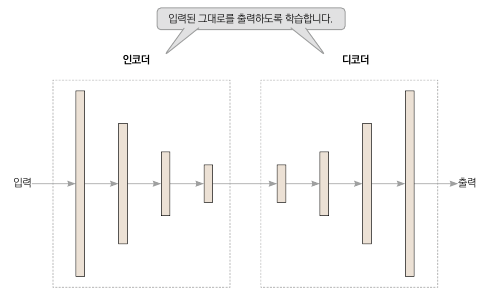

단점
  - 인코더의 특징을 디코더가 사용하지 않음
  - 학습이 안되면.. 어느쪽 문제인지 알아내기가 쉽지 않다

장정
  - 이미지 복원
  - 인코더만 따로 사용해서 이미지 추출기
  - 디코더만 따로  사용해서 이미지를 만드는데 활용

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

def gaussian_noise(x, scale = 0.8):
  gaussian_data_x =  x + np.random.normal(
      loc=0,scale=scale,size=x.shape
  )
  # 0 과 1사이로 정규화
  gaussian_data_x = np.clip(gaussian_data_x,0,1)
  gaussian_data_x = torch.tensor(gaussian_data_x)
  gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
  return gaussian_data_x

100%|██████████| 9912422/9912422 [00:00<00:00, 355035406.82it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 128730811.72it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 192316437.16it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23519171.32it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




<ipython-input-1-a16cb1486dff>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


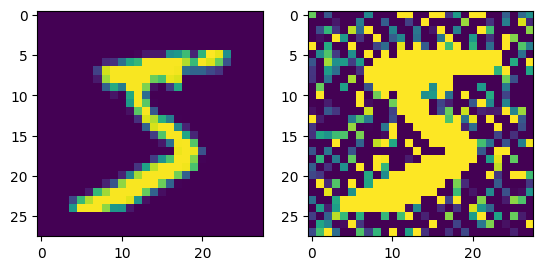

In [2]:
train_dataset = MNIST(root='./', train=True, download=True,transform=ToTensor())
test_dataset = MNIST(root='./', train=False, download=True,transform=ToTensor())
img = train_dataset.data[0]
gaussian =gaussian_noise(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(gaussian)
plt.show()

In [4]:
from torch.utils.data.dataset import Dataset
class Denoising(Dataset):
  def __init__(self):
    # 원본
    self.mnist = MNIST(root='./', train=True, download=True,transform=ToTensor())
    self.data = [] # 노이즈가 낀 데이터

    for i in range(len(self.mnist)):
      noisy_input = gaussian_noise(self.mnist.data[i])
      input_tensor =  torch.tensor(noisy_input)
      self.data.append(torch.unsqueeze(input_tensor,dim=0))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    data = self.data[index]
    # 정규화.. 0 ~ 1
    label = self.mnist.data[index] / 255
    return data, label

모델 정의

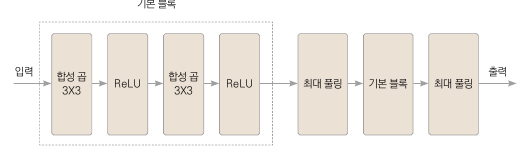

In [8]:
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self,in_channel, out_channel, hidden_dim):
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(in_channel,hidden_dim,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(hidden_dim,out_channel,kernel_size=3,padding=1)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x

In [9]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.conv1 = BasicBlock(in_channel=1,out_channel=16,hidden_dim=16)
    self.conv2 = BasicBlock(in_channel=16,out_channel=8,hidden_dim=8)
    self.pool = nn.AvgPool2d(kernel_size=2,stride=2)
  def forward(self,x):
    x = self.conv1(x)
    x= self.pool(x)
    x = self.conv2(x)
    x= self.pool(x)
    return x

디코더

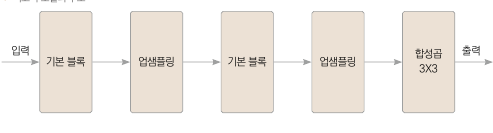

In [ ]:
class Decoder(nn.modules):
  pass

In [10]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.conv1 = BasicBlock(in_channel=8,out_channel=8,hidden_dim=8)
    self.conv2 = BasicBlock(in_channel=8,out_channel=16,hidden_dim=16)
    self.conv3 = nn.Conv2d(in_channels=16,out_channels=1,kernel_size=3,padding=1)
    self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size=2,stride=2)
    self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size=2,stride=2)
  def forward(self,x):
    x = self.conv1(x)
    x = self.upsample1(x)
    x = self.conv2(x)
    x = self.upsample2(x)
    x = self.conv3(x)
    return x

CAE
  - 단순히 인코더와 디코더를 쌓는다

In [11]:
class CAE(nn.Module):
  def __init__(self):
    super(CAE,self).__init__()

    self.enc = Encoder()
    self.dec = Decoder()
  def forward(self,x):
    x =self.enc(x)
    x =self.dec(x)
    x = torch.squeeze(x)  # 채널 정보 삭제
    return x

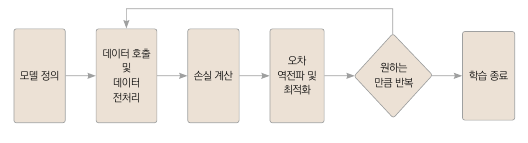

In [12]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train = Denoising()
train_loader = DataLoader(train,batch_size=32)
model = CAE().to(device)

lr = 1e-4
optim = Adam(model.parameters(),lr=lr)
for epoch in range(20):
  iterdata = tqdm.tqdm(train_loader)
  for data,label in iterdata:
    optim.zero_grad()
    pred = model(data.to(device))

    loss = nn.MSELoss()(torch.squeeze(pred),label.to(device))
    loss.backward()
    optim.step()
    iterdata.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
torch.save(model.state_dict(), 'CAE.pth')

<ipython-input-1-a16cb1486dff>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
<ipython-input-4-71756f483c36>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor =  torch.tensor(noisy_input)
epoch:20 loss:0.009369486011564732: 100%|██████████| 1875/1875 [01:02<00:00, 30.02it/s]


평가


<ipython-input-1-a16cb1486dff>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


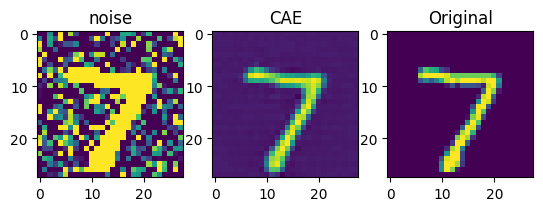

In [14]:
with torch.no_grad():
  model.load_state_dict(torch.load('CAE.pth',map_location=device))

  img = test_dataset.data[0]
  gaussian = gaussian_noise(img)

  #모델의 모양에 맞게 채널 차원 추가
  input = torch.unsqueeze(gaussian,dim=0)
  input.type(torch.FloatTensor)
  input.to(device)
  input = torch.unsqueeze(input,dim=0)  # 배치크기 1을 위한 차원 추가

  plt.subplot(1,3,1)
  plt.imshow(torch.squeeze(gaussian))
  plt.title("noise")
  plt.subplot(1,3,2)
  plt.imshow(torch.squeeze(model(input)))
  plt.title("CAE")
  plt.subplot(1,3,3)
  plt.imshow(torch.squeeze(img))
  plt.title("Original")
  plt.show()
